## Conditionally adding new particles during a simulation

For certain of Lagrangian simulations, it might be desirable to add new particules dependent on some conditional statement. For example, one could be considering particle fragmention and want to add new particles to the simulation if a Parcels particle has e.g. spent $x$ days on a beach or been exposed to $y$ amount of UV radiation. At the moment, dynamically adding particles to a simulation during the simulation itself is not yet an built-in feature of Parcels, but the approach described is a simple hack to get around this.

For simplicity, the example below deals with a very simple conditional statement, where each particle within the simulation spawns a new particle every 5 integration timesteps. However, more elaborate conditional statements are of course possible.

In [1]:
from parcels import Variable, FieldSet, ParticleSet, JITParticle, AdvectionRK4, DiffusionUniformKh, plotTrajectoriesFile, ParcelsRandom
import numpy as np
from operator import attrgetter
from datetime import timedelta
import matplotlib.pyplot as plt


First, we have to set up the basic simulation parameters. For this example, we use surface currents from the CMEMS Mediterranean Sea Physics reanalysis, and add horizontal diffusion with $K_h=10$ m$^2$ s$^{-1}$.

Next, we define the particle class, where in this example we need to add two variables. The variable `to_split` tracks whether a particle has met the conditions for generating a new particle. If yes, then the kernel will set `particle.to_split = 1`. We also add the variable `age_counter`, which tracks the age of that particle. When `particle.age_counter` is greater than a given threshold (in this case it will be 5 integration timesteps), then `particle.to_split = 1` and the `particle.age_counter` will be reset such that `particle.age_counter = 0`.

Finally, we create the `ParticleSet`, but this doesn't require any settings that are out of the ordinary.

In [2]:
# Some basic parameters
integration_timestep = timedelta(minutes=10)
output_timestep = timedelta(minutes=10)
start_lon, start_lat = 5, 40

# Getting the fieldset
def create_fieldset(Kh=10):
    file_names = {'U': "20100101_d-CMCC--RFVL-MFSe3r1-MED-b20200901_re-sv01.00.nc",
                  'V': "20100101_d-CMCC--RFVL-MFSe3r1-MED-b20200901_re-sv01.00.nc"}
    variables = {'U': 'uo', 'V': 'vo'}
    dimensions = {'time': 'time', 'lon': 'lon', 'lat': 'lat', 'depth': 'depth'}
    fieldset = FieldSet.from_netcdf(file_names, variables, dimensions, allow_time_extrapolation=True)

    fieldset.add_constant_field("Kh_zonal", Kh, mesh='spherical')
    fieldset.add_constant_field("Kh_meridional", Kh, mesh='spherical')
    
    return fieldset

# Creating the particle class
class BaseParticle(JITParticle):
    to_split = Variable('to_split', dtype=np.int32, initial=0)
    age_counter = Variable('age_counter', dtype=np.float32, initial=0)

# Creating the particle set
def create_pset(start_lon, start_lat, particle_number=1, Kh=10):
    fieldset = create_fieldset(Kh=Kh)
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=BaseParticle, 
                                 lon=[start_lon] * particle_number, 
                                 lat=[start_lat] * particle_number)
    return pset


Next, we specify a number of kernels and functions. First, we have `particle_to_split()`, which sets `particle.to_split = 1` when the `particle.age_counter` is greater than or equal to 5 integration timesteps. Meanwhile, there is also a second kernel `age_counter()`, which simply increases the `particle.age_counter` by the integration time step.

Finally, there is the `particle_splitter()` function. This is not a kernel that is run by parcels, but instead a function that is called after each integration time step. It checks each particle in the pset to see if any have `particle.to_split == 1`. Then it saves all the new particle parameters within the `new_dict` dictionary. In this case we are creating new particles with the same position as the original parent particle, but this can depend on the particular model scenario. Also, it is important to specify the time variable of the new particles, as otherwise they start with the default time of the pset (which is the starting time of the simulation). Once all particles in the `pset` have been checked, the splitter checks if there are new particles to add. If yes, a `ParticleSet` object `pset_new` is created that contains all the new particles, and this is then added to `pset`.

In [3]:
# Creating the kernel
def particle_to_split(particle, fieldset, time):
    if particle.age_counter >= (5 * particle.dt):
        particle.to_split = 1
        particle.age_counter = 0

# Creating the kernel
def age_counter(particle, fieldset, time):
    particle.age_counter += particle.dt

def particle_splitter(pset):
    # Initialize the dictionary containing the new particles
    new_dict = {'count': 0, 'lon': np.array([]), 'lat': np.array([]), 'time': np.array([])}
    
    # Check each particle in the pset to see if any particles have met the splitting condition
    for particle in pset:
        if particle.to_split > 0:
            # First, we reset the split condition statement back to 0
            particle.to_split = 0
            
            # Then, we update new_dict with all the parameter values for the new particles
            new_dict['count'] += 1
            new_dict['lon'] = np.append(new_dict['lon'], particle.lon)
            new_dict['lat'] = np.append(new_dict['lat'], particle.lat)
            new_dict['time'] = np.append(new_dict['time'], particle.time)
            

    # if there are new particles to be created, create a pset_new object and add this to the original pset object
    if new_dict['count'] > 0:
        pset_new = ParticleSet(fieldset=pset.fieldset, pclass=BaseParticle, 
                               lon=new_dict['lon'], lat=new_dict['lat'], time=new_dict['time'], repeatdt=None)
        pset.add(pset_new)
    return pset
    

Now we shall show an example of how the `particle_splitter()` function can be implemented. Below we run a short simulation (20 integration timesteps) with just one particle. As is shown by the blue trajectory, the particle starts at 40$^{\circ}$N, 5$^{\circ}$E, and is then transported southwest by a combination of advection and diffusion.

In [4]:
# running the simulation
pset = create_pset(start_lon=start_lon, start_lat=start_lat)
pfile = pset.ParticleFile(name='example_output.nc', outputdt=integration_timestep)
kernel = pset.Kernel(AdvectionRK4) + pset.Kernel(DiffusionUniformKh)

ParcelsRandom.seed(1)
pset.execute(kernel, 
             runtime=integration_timestep * 20, dt=integration_timestep,
             output_file=pfile)
pfile.export()

INFO: Compiled ParcelsRandom ==> /var/folders/ck/b7sy8j_944j0g77pl03dpn4m0000gn/T/parcels-501/libparcels_random_6fab0174-b9ea-4ab1-85f9-c031dcda64ef.so
INFO: Compiled ArrayBaseParticleAdvectionRK4DiffusionUniformKh ==> /var/folders/ck/b7sy8j_944j0g77pl03dpn4m0000gn/T/parcels-501/lib049c67b817f202e7204099f8ae6628a5_0.so


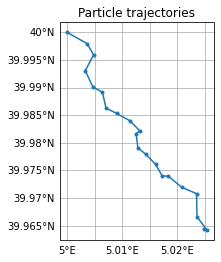

<module 'matplotlib.pyplot' from '/Users/victoronink/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [5]:
plotTrajectoriesFile('example_output.nc')

The example below now shows that happens when the `particle_splitter()` function is implemented. The kernel has been expanded to include the `age_counter` and `particle_to_split` kernels. The main difference in the simulation is how `pset.execute()` is implemented. In the previous example we simply specified that the `pset.execute(runtime=integration_timestep * 20)`. However, below we have implemented a while loop where each time we do `pset.execute(runtime=integration_timestep)` and the while loop checks if the simulation has run for 20 timesteps yet or not. Each time after we run `pset.execute()` we then call the `particle_splitter()` to add any new particles, followed by increasing `simulation_time` by one integration timestep. Once the while statement no longer holds, the simulation is done.

In [6]:
# running the simulation
pset = create_pset(start_lon=start_lon, start_lat=start_lat)
pfile = pset.ParticleFile(name='example_output_split.nc', outputdt=integration_timestep)
kernel = pset.Kernel(AdvectionRK4) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(age_counter) + pset.Kernel(particle_to_split)


simulation_time = 0
ParcelsRandom.seed(1)
while simulation_time < (output_timestep.total_seconds() * 20):
    # Execute the pset for one timestep
    pset.execute(kernel, runtime=output_timestep, dt=integration_timestep,
                 output_file=pfile)
    # Check if we need to add new particles
    pset = particle_splitter(pset)
    # Increase the simulation time by one integration timestep
    simulation_time += integration_timestep.total_seconds()
pfile.export()

INFO: Compiled ArrayBaseParticleAdvectionRK4DiffusionUniformKhage_counterparticle_to_split ==> /var/folders/ck/b7sy8j_944j0g77pl03dpn4m0000gn/T/parcels-501/lib9677f67f21a5c2c54d50ba699d785f45_0.so
/Users/victoronink/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


As we can see in the trajectory plot below, every 5 timesteps new particles are added. The starting positions of these new particles doesn't seem to overlap with the parent particles, but that is because the new particles are only added to the `output_file` after they have been advected for one integration timestep. Therefore, while the particles do start at the same position as the parent object, it does not appear so in the output file.

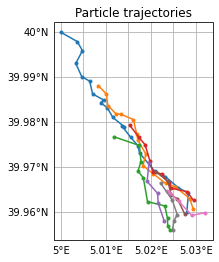

<module 'matplotlib.pyplot' from '/Users/victoronink/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [7]:
plotTrajectoriesFile('example_output_split.nc')


Some final remarks:
- Note that with conditional statements such as in this example the number of particles in your simulation can rise exponentially. Therefore, keep this in mind when setting up your simulations and estimating how much time it will take.
- In this case, we run the particle splitter after every integration timestep, which in this scenario is the same as the `outputdt` of `pset.ParticleFile()`. However, this does mean that the particle positions for each time step is saved, and for long simulations with lots of particles this can lead to large storage requirements. As such, it is recommended that the `output_timestep` is longer than the `integration_timestep`. This does mean that particles would not be added after every integration timestep, but depending on simulation goal this might not be problematic (e.g. only checking if new particles need to be added after every 12 simulation hours, when the integration time step might be 30 seconds).